In [1]:
%pip install pillow
%pip install opencv-python
%pip install pytesseract
%pip install matplotlib
%pip install pandas

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
import cv2
from PIL import Image
import pytesseract
from matplotlib import pyplot as plt
import numpy as np
from pathlib import Path
import pandas as pd
import re
import os

In [3]:
#using pillow to open image
file = "data/150.png"
im = Image.open(file)
im.show()

In [4]:
#using opencv to open image
img = cv2.imread(file)

In [5]:
def display(im_path):

    dpi = 80
    im_data = plt.imread(im_path)
    if len(im_data.shape) == 3:
        height, width, depth = im_data.shape
    else:
        height, width = im_data.shape

    # What size does the figure need to be in inches to fit the image?
    figsize = width / float(dpi), height / float(dpi)

    # Create a figure of the right size with one axes that takes up the full figure
    fig = plt.figure(figsize=figsize)
    ax = fig.add_axes([0, 0, 1, 1])

    # Hide spines, ticks, etc.
    ax.axis('off')

    # Display the image.
    ax.imshow(im_data, cmap='gray')

    plt.show()

In [6]:
# full function for model
import cv2
from PIL import Image
import pytesseract
from matplotlib import pyplot as plt
import numpy as np
from pathlib import Path
import pandas as pd
import re
import os

# function to batch process images
def batch_return_img(number):
  return str(number) + ".png"

# function for pytesseract
def ocr(file_path):
  img = Image.open(file_path)
  ocr_result = pytesseract.image_to_string(img)
  return ocr_result

In [56]:
def is_similar(str1, str2):
    # If the strings are the same, return True
    if str1 == str2:
        return True

    # Calculate the difference in length between the two strings
    diff_len = abs(len(str1) - len(str2))

    # If the difference in length is more than 2, return False
    if diff_len > 2:
        return False

    # Count the number of different characters at the same position
    diff_count = sum(1 for c1, c2 in zip(str1, str2) if c1 != c2)

    # If the total difference is 2 or less, return True
    return diff_count <= 2


def replace_units(text):
    # Replace 'milligram' with 'mg'
    text = re.sub(r'\bmilligram\b', 'mg', text, flags=re.IGNORECASE)
    # Replace 'microgram' with 'mcg'
    text = re.sub(r'\bmicrogram\b', 'mcg', text, flags=re.IGNORECASE)
    # Replace 'milligrams' with 'mg'
    text = re.sub(r'\bmilligrams\b', 'mg', text, flags=re.IGNORECASE)
    # Replace 'micrograms' with 'mcg'
    text = re.sub(r'\bmicrograms\b', 'mcg', text, flags=re.IGNORECASE)

    text = text.replace(" ", "")
    return text


# Define a mapping function to replace "Smg" with "5mg"
def mapping(dosage_text):
    if "Smg" in dosage_text:
        dosage_text = dosage_text.replace("Smg", "5mg")
    if "SENNOSIOE" in dosage_text:
        dosage_text = dosage_text.replace("SENNOSIOE", "sennoside")
    if "guaifenesin" in dosage_text.lower():
        dosage_text = dosage_text.replace("guaifenesin", "guaiphenesin")
    if "/mi" in dosage_text:
        dosage_text = dosage_text.replace("/mi", "/ml")
        
    return dosage_text
    

In [62]:
# try two types of images jieru modified
# full function for model
def mds21():

  # read dataset
  df = pd.read_csv("../Dataset_13-5-2024/med_data_latest.csv")
  api_list =  ["abacavir", "acamprosate", "acarbose", "acetazolamide", "acetic acid-glacial", "aciclovir", "activated charcoal", "adalimumab", "adapalene", "adrenaline", "agomelatine", "alafenamide", "alendronate", "allopurinol", "alprazolam", "alprostadil", "alteplase", "aluminium hydroxide", "amantadine", "amiloride", "amiodarone", "amiodarone ", "amisulpride", "amitriptyline", "amlodipine", "amlodipine besylate", "ammonium bicarbonate", "amorolfine", "amoxycillin", "amphotericin", "amylmetacresol", "amylmetacresol ", "anastrozole", "antazoline phosphate", "apixaban", "apixaban ", "apomorphine  hemihydrate", "apraclonidine", "arachis oil", "aripiprazole", "aspart  protamine", "aspirin", "atenolol", "atorvastatin", "atorvastatin calcium", "atovaquone", "atropine", "atropine sulfate", "azathioprine", "azelastine ", "azithromycin", "baclofen", "beclomethasone", "beclomethasone dipropionate", "benserazide", "benzalkonium chloride", "benzhexol", "benzocaine", "benzoic acid", "benzonatate", "benzoncaine", "benzoyl peroxide", "benzydamine", "benzydamine ", "benzyl alcohol", "benzyl benzoate", "benzylpenicillin", "betahistine", "betamethasone dipropionate", "betamethasone valerate", "bethanechol", "bictegravir", "bifonazole", "bimatoprost", "biperiden", "bisacodyl", "bisoprolol fumarate", "brimonidine", "bromazepam", "bromhexine", "bromocriptine", "budesonide", "bumetanide", "buprenorphine", "bupropion", "butylated hydroxyanisole", "cabergoline", "caffeine", "calcitriol", "calcium", "calcium carbonate", "calcium chloride", "camphor", "candesartan", "candesartanl", "capecitabine", "captopril", "carbamazepine", "carbamide peroxide", "carbidopa", "carbimazole", "carbomer", "carbomer 580", "carbomer 980", "carmellose", "cefaclor", "cefepime ", "ceftazidime", "ceftriaxone", "cefuroxime", "celecoxib", "cephalexin", "cetalkonium chloride", "cetirizine", "cetrimide", "cetylpyridium chloride", "chloramphenicol", "chlorbutol", "chlorhexidine", "chlorhexidine gluconate", "chlorpromazine", "chlorpromazine ", "cholestyramine", "choline salicylate", "ciclesonide", "ciclosporin", "cinacalcet", "cinchocaine", "ciprofloxacin", "citalopram", "citric acid anhydrous", "clarithromycin", "clavulanic acid", "clindamycin", "clioquinol", "clobazam", "clobetasone butyrate", "clomiphene", "clomipramine", "clonazepam", "clonidine", "clonidine ", "clopidogrel", "clotrimazole", "clove bud oil", "coal tar", "cobicistat", "colchicine", "colecalciferol", "crotamiton", "cyclizine", "cyclizine lactate", "cyclosporin", "cyproheptadine", "cyproterone", "dabigatran", "danaparoid", "desloratadine", "desmopressin", "desogestrel", "desvenlafaxine", "dexamethasone", "dexamphetamine sulphate:dexamphetamine", "dexchlorpheniramine maleate", "dexpanthenol", "dextran", "dextran 70", "dextromethorphan hydrobromide", "dextropropoxyphene", "diazepam", "dichlorobenzyl alcohol", "dichlorobenzyl alcohol ", "diclofenac", "dicloxacillin", "digoxin", "dihydroergotamine", "diltiazem", "diphenoxylate", "dipyridamole", "disodium etidronate", "disopyramide", "docusate", "dolutegravir", "domperidone", "donepezil", "dorzolamide", "dothiepin", "dothiepin hcl", "doxepin", "doxycycline", "doxylamine succinate", "dulaglutide", "dydrogesterone", "econazole", "econazole nitrate", "efavirenz", "eformoterol", "eformoterol = formoterol", "formoterol", "elvitegravir", "emtricitabine", "enalapril", "enoxaparin", "entacapone", "eplerenone", "eprosartan", "eprosartan:mesylate", "erythromycin", "erythromycin ethylsuccinate", "escitalopram", "esomeprazole", "estradiol", "etanercept", "ethanol", "ethinyloestradiol", "ethinyloestriol", "etonogestrel", "eucalyptus oil", "exenatide", "ezetimibe", "famciclovir", "famiciclovir", "famotidine", "felodipine", "fenofibrate", "fentanyl", "ferrous fumarate", "ferrous sulfate", "ferrous sulphate", "fesoterodine", "fexofenadine", "finasteride", "flecainide acetate", "flucloxacillin", "fluconazole", "fludrocortisone", "flumethasone", "flunitrazepam", "fluorometholone", "fluorometholone acetate", "fluorouracil ", "fluoxetine", "fluticasone", "fluticasone furoate", "fluticasone propionate", "fluvastatin", "fluvoxamine", "folic acid", "fosinopril", "framycetin", "frusemide", "frusemide = furosemide", "furosemide", "fusidic acid", "gabapentin", "galantamine", "gemfibrozil", "gestodene", "glibenclamide", "gliclazide", "glimepiride", "glipizide", "glycerin", "glycerol", "glyceryl trin", "glyceryl trinitrate", "glycopyrronium ", "goserelin", "gramicidin", "guaiphenesin", "guaifenesin = guaiphenesin ", "guaifenesin", "haloperidol", "homatropine", "hydralazine", "hydrochlorothiazide", "hydrocortisone", "hydromorphone", "hydroxocobalamin", "hydroxychloroquine", "hyoscine butylbromide", "hyoscine hydrobromide", "hyoscyamine sulfate", "hypromellose", "ibuprofen", "idoxuridine", "imipramine", "imiquimod", "indapamide", "indometacin", "indomethacin = indometacin", "indomethacin", "insulin aspart", "insulin detemir", "insulin glargine", "insulin glarine", "insulin isophane", "insulin lispro", "insulin neutral", "ipratroium bromide", "ipratropium", "irbesartan", "iron polymaltose", "iron, vitamin c", "isophane insulin", "isopropyl alcohol", "isosorbide", "isosorbide dinit", "isosorbide mononitrate", "isotretinoin", "ivermectin", "ketoconazole", "ketoprofen", "ketorolac trometamol", "ketotifen", "labetalol", "lactic acid", "lactulose", "lamivudine", "lamotrigine", "lansoprazole", "latanoprost", "leflunomide", "lercanid", "lercanidipine", "letrozole", "levetiracetam", "levocabastine", "levodopa", "levonorgesterol", "levonorgestrel", "levothyroxine", "lignocaine", "lincomycin", "lisinopril", "lispro protamine", "lithium", "lithium carbonate", "loperamide", "loratadine", "lorazepam", "magnesium alginate", "magnesium carbonate", "magnesium hydroxide", "magnesium tricilicate", "maldison", "mebendazole", "medroxyprogesterone", "medroxyprogesterone acetate", "mefenamic acid", "mefloquine", "melatonin", "meloxicam", "memantine", "menthol", "menthol ", "mercaptopurine", "mesalazine", "mestranol", "metformin", "metformin xr", "methadone", "methotrexate", "methylphenidate", "methylprednisolone", "metoclopramide", "metolazone", "metoprolol", "metoprolol succinate", "metoprolol tartrate", "metronidazole", "mianserin", "miconazole", "miconazole nitrate", "minocycline", "mirtazapine", "moclobemide", "mometasone furoate", "montelukast", "morphine", "morphine sulfate", "morphine sulphate", "moxonidine", "mupirocin", "mupirocin ", "naltrexone", "naphazoline ", "naphazoline hcl", "naproxen", "naratriptan", "nedocromil", "neomycin", "neutral insulin", "nicorandil", "nicotine", "nifedipine", "nitrazepam", "nitrofurantoin", "nizatidine", "norethisterone", "norfloxacin", "nortriptyline", "nystatin", "oestradiol", "oestriol ", "oestrogens conjugated", "ofloxacin", "olanzapine", "olmesartan", "olopatadine", "olsalazine", "omeprazole", "ondansetron", "orphenadrine citrate", "ortho-dichlorobenzene", "oseltamivir", "oxazepam", "oxpentifylline", "oxybutynin", "oxycodone", "oxymetazoline ", "pantoprazole", "para-dichlorobenzene", "paracetamol", "paroxetine", "pergolide mesylate", "perhexiline maleate", "pericyazine", "permethrin", "peru balsam", "pethidine", "phenazone", "pheniramine maleate", "phenobarbitone", "phenol", "phenoxymethylpenicillin", "phentermine", "phenylephine", "phenylephrine", "phenylephrine ", "phenytoin", "pilocarpine ", "pimecrolimus", "pindolol", "pioglitazone", "piroxicam", "pizotifen", "podophyllum resin", "poloxamer", "polyethylene glycol", "polysorbate 80", "polyvinyl alcohol", "potassium bicarbonate", "potassium chlor", "potassium chloride", "potassium clavulanic", "potassium dihydrogen phosphate", "povidone", "pramipexole", "prasugrel", "pravastatin", "prazosin", "prednisolone", "prednisone", "pregabalin", "primidone", "probenecid", "procaine penicill", "prochlorperazine", "prochlorperazine maleate", "prochlorperazine mesylate", "proguanil", "propantheline", "propranolol", "propylene glycol", "pseudoephedrine", "pseudoephedrine sulfate", "pyrantel", "quetiapine", "quetiapine fumarate", "quinapril", "quinine bisulphate", "quinine sulphate", "rabeprazole", "raloxifene", "ramipril", "ranolazine", "reboxetine", "rilpivirine", "risedronate", "risperidone", "rivaroxaban", "rivastigmine", "rizatriptan", "rosiglitazone", "rosuvastatin", "roxithromycin", "salbutamol", "salicylic acid", "salmeterol", "selegiline", "sennosides", "sertraline", "sevelamer", "sildenafil", "silver sulfadiazine", "simethicone", "simvastatin", "sitagliptin", "sodium alginate", "sodium bicarbonate", "sodium carbonate", "sodium chloride", "sodium citrate", "sodium cromoglycate", "sodium fusidate", "sodium lauryl sulfoacetate", "sodium sulfite", "sodium valproate", "solifenacin", "sorbitol", "sotalol", "sotalol ", "spironolactone", "sucralfate", "sulfamethoxazole", "sulfasalazine", "sulindac", "sumatripan", "sumatriptan", "tacrolimus", "tamoxifen", "tamoxifen citrate", "tamsulosin", "tar", "telmisartan", "temazepam", "tenofovir", "tenofovir alafenamide", "terazosin", "terbinafine", "terbinafine ", "testosterone", "testosterone undecanoate", "tetrahydrozoline", "tetrahydrozoline ", "theophylline", "thyroxine", "tiaprofenic acid", "tibolone", "tilactase", "timolol", "timolol ", "tinidazole", "tiotropium", "tobramycin", "tobramycin ", "topiramate", "tramadol", "tramazoline ", "trandolapril", "tranylcypromine", "travoprost", "trazodone", "tretinoin", "triamcinolone", "triamcinolone acetonide", "triclosan", "triethanolamine lauryl sulfate", "trifluoperazine", "trimeprazine", "trimethoprim", "ulipristal acetate", "ursodeoxycholic", "valaciclovir", "valsartan", "vardenafil", "varenicline", "venlafaxine", "verapamil", "vildagliptin", "vortioxetine", "warfarin", "xylometazoline", "xylometazoline ", "zinc oxide", "ziprasidone", "zolmitriptan", "zolpidem", "zopiclone"]

  # store total success and failure for model
  true = 0
  false = 0

  for i in range(1, 523): # modify back to 1525

    # batch process images
    img_number = batch_return_img(i)

    # file_paths
    # inverted images
    file_path = "../Image Pre-Processing/output_folder/"+ str(img_number)
    # threshold images
    file_path2 = "../Image Pre-Processing/adaptive thresh2/"+ str(img_number) 
    print(file_path)
    print(file_path2)

    if Path(file_path).is_file() and Path(file_path2).is_file():

      # ocr image then remove temp file from system to prevent clogging
      ocr_results = ocr(file_path)
      ocr_results2 = ocr(file_path2)
      # os.remove(file_path)

      # post process ocr results 
      ocr_results_list = ocr_results.split("\n") 
      for j in range(len(ocr_results_list)):
        ocr_results_list[j] = ocr_results_list[j].replace("\n", " ")
      print(ocr_results_list)

      ocr_results_list2 = ocr_results2.split("\n") 
      for j in range(len(ocr_results_list2)):
        ocr_results_list2[j] = ocr_results_list2[j].replace("\n", " ")
      print(ocr_results_list2)

      # create final list
      final_list = [[],[]]

      pattern = r'\d+\s?(?:mg|mcg|% w/w|% w/v|% v/v|g/g|mg/g|micrograms|milligrams|mg/ml|mg/5ml|mg/1ml)'

      # get the dosage (for inverted)
      for item in ocr_results_list:
        item2 = mapping(item)
        match = re.search(pattern, item2)          
        if match:
          final_list[1].append(match.group())
          print(match)

        # get the api (for inverted)
        for api in api_list:
          if api in item2.lower():
            if api not in final_list[0]:
              final_list[0].append(api)

      # get the dosage (for threshold)
      for item in ocr_results_list2:
        item2 = mapping(item)
        match = re.search(pattern, item2)          
        if match and match.group() not in final_list[1]:
          final_list[1].append(match.group())
          print(match)
    
        # get the api (for threshold)
        for api in api_list:
          if api in item2.lower():
            if api not in final_list[0]:
              final_list[0].append(api)
      
      # remove the space
      for j in range(len(final_list[1])):   
        final_list[1][j] = replace_units(final_list[1][j])

      # get the row of the current medicine box from csv dataframe
      print("The row number now is: " + str(i))
      row = df.loc[df['id'] == i]
      print(row)

      
      # match api and dosage
      if len(final_list[0]) < len(final_list[1]):
        for i in final_list[1]:
          if i not in row['dosage'].values[0]:
            final_list[1].remove(i)

      # check when the api list is larger than dosage list
      while len(final_list[0]) > len(final_list[1]):
        for i in final_list[0]:
          # if there are other api accidentally read (e.g. 'tar' from 'vatarlen')
          if i not in row['api'].values[0]:
            final_list[0].remove(i)
       
        #  # if there is substring of the api which is also api then remove (loratadine vs desloratadine)
        api_list = final_list[0]  # Store the API list temporarily

        # Iterate over a copy of the list to avoid modifying it while iterating
        for api in api_list[:]:
          for other_api in api_list:
            if api != other_api and api in other_api:
              api_list.remove(api)  # Remove the substring from the list

        final_list[0] = api_list  # Update the API list

        # if the dosage is not completed then false
        if len(final_list[0]) > len(final_list[1]):
          false += 1
          break
      print(final_list)

      # if more than one api
      if len(final_list[0]) > 1 and len(final_list[0]) == len(final_list[1]):
        checked = 0
        len_list = len(final_list[0])
        for i in range(len(final_list[0])):
          # if api and dosage is in the row
          if final_list[0][i] in row['api'].values[0] and final_list[1][i] in row['dosage'].values[0]:
            checked += 1
            if checked == len_list:
              true += 1
              print("\nok\n")
          else:
            false += 1
            break

      # if only one api
      elif len(final_list[0]) == 1 and len(final_list[1]) == 1:
        print("halo")
        # if api and dosage is in the row
        if final_list[0][0] in row['api'].values[0] and final_list[1][0] in row['dosage'].values[0]:
          true += 1
          print("\nok\n")
        else:
          false += 1

    else:
      print(img_number + " does not exist")
      continue
    
  accuracy = (true / (true + false)) * 100

  print("The accuracy is: " + str(accuracy) + "%\n")

mds21()

../Image Pre-Processing/output_folder/1.png
../Image Pre-Processing/adaptive thresh2/1.png
['——E—', 'Dulcelax', '', 'COATED TABLETS', 'Eien', '', 'Dependable,', 'effective', "' constipation relief", '', ' ', '\x0c']
['——E—', 'Dulcelax', '', 'COATED TABLETS', 'Bisacodyl Smg', '', 'Dependable,', 'effective', '| constipation relief', '', ' ', '\x0c']
<re.Match object; span=(10, 13), match='5mg'>
The row number now is: 1
   id brand_name        api dosage    type  pack_size brand
0   1   dulcolax  bisacodyl    5mg  tablet        1.0   NaN
[['bisacodyl'], ['5mg']]
halo

ok

../Image Pre-Processing/output_folder/2.png
../Image Pre-Processing/adaptive thresh2/2.png
['PHARMACIST ONLY MEDICINE', '', 'KEEP OUT OF REACH OF CHLDRE', '', 'FANG for Cold Sores)', '', 'famciclovir 500 mg:', 'G@)rablets [Teese ies @espen', '', ' ', '\x0c']
['PHARMACIST ONLY MEDICINE', '', 'KEEP OUT OF REACH OF CHLDRE', '', 'FANG for Cold Sores)', '', 'famciclovir 500 mg:', '(OVasESe @espen', '', ' ', '\x0c']
<re.Match 

In [31]:
# full function for model
def mds21():

  # read dataset
  df = pd.read_csv("../Dataset_30-4-2024/0 med_data_latest.csv")
  api_list = ["abacavir", "acamprosate", "acarbose", "acetazolamide", "acetic acid-glacial", "aciclovir", "activated charcoal", "adalimumab", "adapalene", "adrenaline", "agomelatine", "alafenamide", "alendronate", "allopurinol", "alprazolam", "alprostadil", "alteplase", "aluminium hydroxide", "amantadine", "amiloride", "amiodarone", "amiodarone ", "amisulpride", "amitriptyline", "amlodipine", "amlodipine besylate", "ammonium bicarbonate", "amorolfine", "amoxycillin", "amphotericin", "amylmetacresol", "amylmetacresol ", "anastrozole", "antazoline phosphate", "apixaban", "apixaban ", "apomorphine  hemihydrate", "apraclonidine", "arachis oil", "aripiprazole", "aspart  protamine", "aspirin", "atenolol", "atorvastatin", "atorvastatin calcium", "atovaquone", "atropine", "atropine sulfate", "azathioprine", "azelastine ", "azithromycin", "baclofen", "beclomethasone", "beclomethasone dipropionate", "benserazide", "benzalkonium chloride", "benzhexol", "benzocaine", "benzoic acid", "benzonatate", "benzoncaine", "benzoyl peroxide", "benzydamine", "benzydamine ", "benzyl alcohol", "benzyl benzoate", "benzylpenicillin", "betahistine", "betamethasone dipropionate", "betamethasone valerate", "bethanechol", "bictegravir", "bifonazole", "bimatoprost", "biperiden", "bisacodyl", "bisoprolol fumarate", "brimonidine", "bromazepam", "bromhexine", "bromocriptine", "budesonide", "bumetanide", "buprenorphine", "bupropion", "butylated hydroxyanisole", "cabergoline", "caffeine", "calcitriol", "calcium", "calcium carbonate", "calcium chloride", "camphor", "candesartan", "candesartanl", "capecitabine", "captopril", "carbamazepine", "carbamide peroxide", "carbidopa", "carbimazole", "carbomer", "carbomer 580", "carbomer 980", "carmellose", "cefaclor", "cefepime ", "ceftazidime", "ceftriaxone", "cefuroxime", "celecoxib", "cephalexin", "cetalkonium chloride", "cetirizine", "cetrimide", "cetylpyridium chloride", "chloramphenicol", "chlorbutol", "chlorhexidine", "chlorhexidine gluconate", "chlorpromazine", "chlorpromazine ", "cholestyramine", "choline salicylate", "ciclesonide", "ciclosporin", "cinacalcet", "cinchocaine", "ciprofloxacin", "citalopram", "citric acid anhydrous", "clarithromycin", "clavulanic acid", "clindamycin", "clioquinol", "clobazam", "clobetasone butyrate", "clomiphene", "clomipramine", "clonazepam", "clonidine", "clonidine ", "clopidogrel", "clotrimazole", "clove bud oil", "coal tar", "cobicistat", "colchicine", "colecalciferol", "crotamiton", "cyclizine", "cyclizine lactate", "cyclosporin", "cyproheptadine", "cyproterone", "dabigatran", "danaparoid", "desloratadine", "desmopressin", "desogestrel", "desvenlafaxine", "dexamethasone", "dexamphetamine sulphate:dexamphetamine", "dexchlorpheniramine maleate", "dexpanthenol", "dextran", "dextran 70", "dextromethorphan hydrobromide", "dextropropoxyphene", "diazepam", "dichlorobenzyl alcohol", "dichlorobenzyl alcohol ", "diclofenac", "dicloxacillin", "digoxin", "dihydroergotamine", "diltiazem", "diphenoxylate", "dipyridamole", "disodium etidronate", "disopyramide", "docusate", "dolutegravir", "domperidone", "donepezil", "dorzolamide", "dothiepin", "dothiepin hcl", "doxepin", "doxycycline", "doxylamine succinate", "dulaglutide", "dydrogesterone", "econazole", "econazole nitrate", "efavirenz", "eformoterol", "eformoterol = formoterol", "formoterol", "elvitegravir", "emtricitabine", "enalapril", "enoxaparin", "entacapone", "eplerenone", "eprosartan", "eprosartan:mesylate", "erythromycin", "erythromycin ethylsuccinate", "escitalopram", "esomeprazole", "estradiol", "etanercept", "ethanol", "ethinyloestradiol", "ethinyloestriol", "etonogestrel", "eucalyptus oil", "exenatide", "ezetimibe", "famciclovir", "famiciclovir", "famotidine", "felodipine", "fenofibrate", "fentanyl", "ferrous fumarate", "ferrous sulfate", "ferrous sulphate", "fesoterodine", "fexofenadine", "finasteride", "flecainide acetate", "flucloxacillin", "fluconazole", "fludrocortisone", "flumethasone", "flunitrazepam", "fluorometholone", "fluorometholone acetate", "fluorouracil ", "fluoxetine", "fluticasone", "fluticasone furoate", "fluticasone propionate", "fluvastatin", "fluvoxamine", "folic acid", "fosinopril", "framycetin", "frusemide", "frusemide = furosemide", "furosemide", "fusidic acid", "gabapentin", "galantamine", "gemfibrozil", "gestodene", "glibenclamide", "gliclazide", "glimepiride", "glipizide", "glycerin", "glycerol", "glyceryl trin", "glyceryl trinitrate", "glycopyrronium ", "goserelin", "gramicidin", "guaiphenesin", "guaifenesin = guaiphenesin ", "guaifenesin", "haloperidol", "homatropine", "hydralazine", "hydrochlorothiazide", "hydrocortisone", "hydromorphone", "hydroxocobalamin", "hydroxychloroquine", "hyoscine butylbromide", "hyoscine hydrobromide", "hyoscyamine sulfate", "hypromellose", "ibuprofen", "idoxuridine", "imipramine", "imiquimod", "indapamide", "indometacin", "indomethacin = indometacin", "indomethacin", "insulin aspart", "insulin detemir", "insulin glargine", "insulin glarine", "insulin isophane", "insulin lispro", "insulin neutral", "ipratroium bromide", "ipratropium", "irbesartan", "iron polymaltose", "iron, vitamin c", "isophane insulin", "isopropyl alcohol", "isosorbide", "isosorbide dinit", "isosorbide mononitrate", "isotretinoin", "ivermectin", "ketoconazole", "ketoprofen", "ketorolac trometamol", "ketotifen", "labetalol", "lactic acid", "lactulose", "lamivudine", "lamotrigine", "lansoprazole", "latanoprost", "leflunomide", "lercanid", "lercanidipine", "letrozole", "levetiracetam", "levocabastine", "levodopa", "levonorgesterol", "levonorgestrel", "levothyroxine", "lignocaine", "lincomycin", "lisinopril", "lispro protamine", "lithium", "lithium carbonate", "loperamide", "loratadine", "lorazepam", "magnesium alginate", "magnesium carbonate", "magnesium hydroxide", "magnesium tricilicate", "maldison", "mebendazole", "medroxyprogesterone", "medroxyprogesterone acetate", "mefenamic acid", "mefloquine", "melatonin", "meloxicam", "memantine", "menthol", "menthol ", "mercaptopurine", "mesalazine", "mestranol", "metformin", "metformin xr", "methadone", "methotrexate", "methylphenidate", "methylprednisolone", "metoclopramide", "metolazone", "metoprolol", "metoprolol succinate", "metoprolol tartrate", "metronidazole", "mianserin", "miconazole", "miconazole nitrate", "minocycline", "mirtazapine", "moclobemide", "mometasone furoate", "montelukast", "morphine", "morphine sulfate", "morphine sulphate", "moxonidine", "mupirocin", "mupirocin ", "naltrexone", "naphazoline ", "naphazoline hcl", "naproxen", "naratriptan", "nedocromil", "neomycin", "neutral insulin", "nicorandil", "nicotine", "nifedipine", "nitrazepam", "nitrofurantoin", "nizatidine", "norethisterone", "norfloxacin", "nortriptyline", "nystatin", "oestradiol", "oestriol ", "oestrogens conjugated", "ofloxacin", "olanzapine", "olmesartan", "olopatadine", "olsalazine", "omeprazole", "ondansetron", "orphenadrine citrate", "ortho-dichlorobenzene", "oseltamivir", "oxazepam", "oxpentifylline", "oxybutynin", "oxycodone", "oxymetazoline ", "pantoprazole", "para-dichlorobenzene", "paracetamol", "paroxetine", "pergolide mesylate", "perhexiline maleate", "pericyazine", "permethrin", "peru balsam", "pethidine", "phenazone", "pheniramine maleate", "phenobarbitone", "phenol", "phenoxymethylpenicillin", "phentermine", "phenylephine", "phenylephrine", "phenylephrine ", "phenytoin", "pilocarpine ", "pimecrolimus", "pindolol", "pioglitazone", "piroxicam", "pizotifen", "podophyllum resin", "poloxamer", "polyethylene glycol", "polysorbate 80", "polyvinyl alcohol", "potassium bicarbonate", "potassium chlor", "potassium chloride", "potassium clavulanic", "potassium dihydrogen phosphate", "povidone", "pramipexole", "prasugrel", "pravastatin", "prazosin", "prednisolone", "prednisone", "pregabalin", "primidone", "probenecid", "procaine penicill", "prochlorperazine", "prochlorperazine maleate", "prochlorperazine mesylate", "proguanil", "propantheline", "propranolol", "propylene glycol", "pseudoephedrine", "pseudoephedrine sulfate", "pyrantel", "quetiapine", "quetiapine fumarate", "quinapril", "quinine bisulphate", "quinine sulphate", "rabeprazole", "raloxifene", "ramipril", "ranolazine", "reboxetine", "rilpivirine", "risedronate", "risperidone", "rivaroxaban", "rivastigmine", "rizatriptan", "rosiglitazone", "rosuvastatin", "roxithromycin", "salbutamol", "salicylic acid", "salmeterol", "selegiline", "sennosides", "sertraline", "sevelamer", "sildenafil", "silver sulfadiazine", "simethicone", "simvastatin", "sitagliptin", "sodium alginate", "sodium bicarbonate", "sodium carbonate", "sodium chloride", "sodium citrate", "sodium cromoglycate", "sodium fusidate", "sodium lauryl sulfoacetate", "sodium sulfite", "sodium valproate", "solifenacin", "sorbitol", "sotalol", "sotalol ", "spironolactone", "sucralfate", "sulfamethoxazole", "sulfasalazine", "sulindac", "sumatripan", "sumatriptan", "tacrolimus", "tamoxifen", "tamoxifen citrate", "tamsulosin", "tar", "telmisartan", "temazepam", "tenofovir", "tenofovir alafenamide", "terazosin", "terbinafine", "terbinafine ", "testosterone", "testosterone undecanoate", "tetrahydrozoline", "tetrahydrozoline ", "theophylline", "thyroxine", "tiaprofenic acid", "tibolone", "tilactase", "timolol", "timolol ", "tinidazole", "tiotropium", "tobramycin", "tobramycin ", "topiramate", "tramadol", "tramazoline ", "trandolapril", "tranylcypromine", "travoprost", "trazodone", "tretinoin", "triamcinolone", "triamcinolone acetonide", "triclosan", "triethanolamine lauryl sulfate", "trifluoperazine", "trimeprazine", "trimethoprim", "ulipristal acetate", "ursodeoxycholic", "valaciclovir", "valsartan", "vardenafil", "varenicline", "venlafaxine", "verapamil", "vildagliptin", "vortioxetine", "warfarin", "xylometazoline", "xylometazoline ", "zinc oxide", "ziprasidone", "zolmitriptan", "zolpidem", "zopiclone"]

  # store total success and failure for model
  true = 0
  false = 0

  for i in range(2, 1651): # modify back to 1525

    # batch process images
    img_number = batch_return_img(i)

    # file_paths
    # ori_file_path = "../Dataset/" + img_number + ".png"
    file_path = "../Image Pre-Processing/output_folder/"+ str(img_number)
    print(file_path)

    if Path(file_path).is_file():

      # read file
      # ori_img = cv2.imread(temp_file_path)

      # preprocess image
      # preprocessed_img = preprocess(ori_img)
      # cv2.imwrite(temp_file_path, preprocessed_img)

      # ocr image then remove temp file from system to prevent clogging
      ocr_results = ocr(file_path)
      # os.remove(file_path)

      # post process ocr results
      ocr_results_list = ocr_results.split("\n\n")
      for j in range(len(ocr_results_list)):
        ocr_results_list[j] = ocr_results_list[j].replace("\n", " ")
      print(ocr_results_list)
      final_list = [[],""]

      pattern = r'\d+\s?(?:mg|mcg|%w/w|g/g|mg/g|micrograms|milligrams)'

      # for sentence in ocr_results_list:

      #   if "contains" in sentence:    # if the word "contains" is in the sentence
      #     clean_ocr_results_list.append(sentence.replace("\n", " "))

      #   if bool(re.search(pattern, sentence)):    # if the word has number followed by unit
      #     clean_ocr_results_list.append(sentence.replace("\n", " "))

      for item in ocr_results_list:
        item2 = mapping(item)
        match = re.search(pattern, item2)
        print(match)
        if match:
          final_list[1] = match.group()
    
        for api in api_list:
          if api in item.lower():
            if api not in final_list[0]:
              final_list[0].append(api)
      
      print(final_list)
      
      print("The row number now is: " + str(i))
      row = df.loc[df['id'] == i]
      print(row)

      # match api and dosage
      if len(final_list[0]) > 1:
        checked = 0
        len_list = len(final_list[0])
        for api in final_list[0]:
          if api in row['api'].values[0]:
            checked += 1
            if checked == len_list:
              true += 1
          else:
            false += 1
            break

      elif len(final_list[0]) == 1:
        if row['api'].values[0] == final_list[0] and row['dosage'].values[0] == replace_units(final_list[1]):
          true += 1
        else:
          false += 1

    else:
      print(img_number + " does not exist")
      continue
    
  accuracy = (true / (true + false)) * 100

  print("The accuracy is: " + str(accuracy) + "%")

mds21()

../Image Pre-Processing/output_folder/2.png
['PHARMACIST ONLY MEDICINE', 'KEEP OUT OF REACH OF CHLDRE', 'FANG for Cold Sores)', 'famciclovir 500 mg: G@)rablets [Teese ies @espen', '  \x0c']
None
None
None
<re.Match object; span=(12, 18), match='500 mg'>
None
[['famciclovir'], '500 mg']
The row number now is: 2
Empty DataFrame
Columns: [id, brand_name, api, dosage, type, pack_size, brand]
Index: []


IndexError: index 0 is out of bounds for axis 0 with size 0

In [9]:
df = pd.read_csv("../Dataset/0 med_data_latest.csv")
row = df.loc[df['id'] == 32]
print(df.loc[df['id'] == 32])
print(row['api'].values[0])
print(row['dosage'].values[0])
# print(df.sample(n=10))

    id             brand_name          api dosage    type pack_size brand
23  32  panadol with optizorb  paracetamol  500mg  tablet         1   NaN
paracetamol
500mg


In [10]:
print(Path("../Dataset/9.png").is_file())
# img = cv2.imread("../Dataset/9.png")
# preprocess(img)
# display("../Dataset/9.png")

False


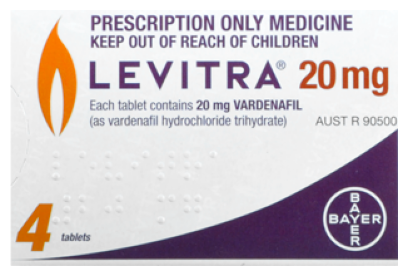

NameError: name 'preprocess' is not defined

In [11]:
img = cv2.imread("../Dataset/1493.png")
display("../Dataset/1493.png")

api_list = ["vardenafil"]

preprocessed_img = preprocess(img)
cv2.imwrite("temp/test.png", preprocessed_img)
display("temp/test.png")

pil_img = Image.open("temp/test.png")
ocr_result = pytesseract.image_to_string(pil_img)
print(ocr_result)

split_list = ocr_result.lower().split("\n\n")
print(split_list)

clean_ocr_results_list = []
final_list = ["",""]

for sentence in split_list:
  if "contains" in sentence or "per" in sentence:
    clean_ocr_results_list.append(sentence.replace("\n", " "))

  pattern = r'\d+\s?(?:mg|mcg|%w/w)'
  
  if bool(re.search(pattern, sentence)):    # if the word has number followed by unit
    clean_ocr_results_list.append(sentence.replace("\n", " "))

  for item in clean_ocr_results_list:
    match = re.search(pattern, item)
    print(match)
    if match:
      final_list[1] = match.group()
    
    for api in api_list:
      if api in item:
        final_list[0] = api

print(clean_ocr_results_list)
print(final_list)

row = df.loc[df['id'] == 1493]

if row['api'].values[0] == final_list[0] and row['dosage'].values[0] == final_list[1]:
  print("True result: " + final_list[0] + " " + final_list[1])




In [ ]:
# function to pull apis from the csv file
import pandas as pd
import numpy as np

df = pd.read_csv("D:\\2024\\FYP\\codebase\\Medication-Dispensing-with-Image-Processing\\Medication-Dispensing-with-Image-Processing\Dataset\\0 med_data_latest.csv")
df['api'] = df['api'].astype(str).fillna('ZZZZZ yo check this out, its empty')
bruh = df['api'].str.split('$').sum()
unique_values_set = set(bruh)
unique_values = list(unique_values_set)
unique_values.sort()
unique_df = pd.DataFrame(unique_values, columns=['API'])
unique_df.to_csv('unique_apis.csv', index=False)


#testing
print("Unique values list:", unique_values)

Unique values list: [' dichlorobenzyl alcohol ', 'Methyl', 'Propyl ', 'abacavir', 'acamprosate', 'acarbose', 'acetazolamide', 'acetic acid-glacial', 'aciclovir', 'activated charcoal', 'adalimumab', 'adapalene', 'adrenaline', 'agomelatine', 'alafenamide', 'alendronate', 'alendronate sodium', 'allopurinol', 'alprazolam', 'alprostadil', 'alteplase', 'aluminium hydroxide', 'amantadine', 'amiloride', 'amiodarone', 'amiodarone ', 'amisulpride', 'amitriptyline', 'amlodipine', 'ammonium bicarbonate', 'amorolfine', 'amoxycillin', 'amphotericin', 'amylmetacresol', 'amylmetacresol ', 'anastrozole', 'antazoline phosphate', 'apixaban', 'apixaban ', 'apomorphine  hemihydrate', 'apraclonidine', 'arachis oil', 'aripiprazole', 'aspart  protamine', 'aspirin', 'atenolol', 'atorvastatin', 'atovaquone', 'atropine', 'atropine sulfate', 'azathioprine', 'azelastine ', 'azithromycin', 'baclofen', 'beclomethasone', 'beclomethasone dipropionate', 'benserazide', 'benzalkonium chloride', 'benzhexol', 'benzocaine',

In [ ]:
img = cv2.imread("../Dataset/1493.png")
display("../Dataset/1493.png")

api_list = ['abacavir', 'acamprosate', 'acarbose', 'acetazolamide', 'acetic acid-glacial', 'aciclovir', 'activated charcoal', 'adalimumab', 'adapalene', 'adrenaline', 'agomelatine', 'alafenamide', 'alendronate', 'alendronate sodium', 'allopurinol', 'alprazolam', 'alprostadil', 'alteplase', 'aluminium hydroxide', 'amantadine', 'amiloride', 'amiodarone', 'amiodarone ', 'amisulpride', 'amitriptyline', 'amlodipine', 'ammonium bicarbonate', 'amorolfine', 'amoxycillin', 'amphotericin', 'amylmetacresol', 'amylmetacresol ', 'anastrozole', 'antazoline phosphate', 'apixaban', 'apixaban ', 'apomorphine  hemihydrate', 'apraclonidine', 'arachis oil', 'aripiprazole', 'aspart  protamine', 'aspirin', 'atenolol', 'atorvastatin', 'atovaquone', 'atropine', 'atropine sulfate', 'azathioprine', 'azelastine ', 'azithromycin', 'baclofen', 'beclomethasone', 'beclomethasone dipropionate', 'benserazide', 'benzalkonium chloride', 'benzhexol', 'benzocaine', 'benzoic acid', 'benzoncaine', 'benzoyl peroxide', 'benzydamine', 'benzydamine ', 'benzyl alcohol', 'benzyl benzoate', 'benzylpenicillin', 'betahistine', 'betamethasone dipropionate', 'betamethasone valerate', 'bethanechol', 'bictegravir', 'bifonazole', 'bimatoprost', 'biperiden', 'bisacodyl', 'bisoprolol fumarate', 'brimonidine', 'bromazepam', 'bromhexine', 'bromocriptine', 'budesonide', 'buprenorphine', 'bupropion', 'butylated hydroxyanisole', 'cabergoline', 'caffeine', 'calcitriol', 'calcium', 'calcium carbonate', 'calcium chloride', 'camphor', 'candesartan', 'candesartanl', 'capecitabine', 'carbamazepine', 'carbamide peroxide', 'carbidopa', 'carbimazole', 'carbomer', 'carbomer 580', 'carbomer 980', 'carmellose', 'carmellose sodium', 'cefaclor', 'cefepime ', 'ceftazidime', 'ceftriaxone', 'cefuroxime', 'celecoxib', 'cephalexin', 'cetalkonium chloride', 'cetirizine', 'cetrimide', 'cetylpyridium chloride', 'chloramphenicol', 'chlorbutol', 'chlorhexidine', 'chlorhexidine gluconate', 'chlorpromazine', 'chlorpromazine ', 'cholestyramine', 'choline salicylate', 'ciclesonide', 'ciclosporin', 'cinacalcet', 'cinchocaine', 'ciprofloxacin', 'citalopram', 'citric acid anhydrous', 'clarithromycin', 'clavulanic acid', 'clindamycin', 'clioquinol', 'clobazam', 'clobetasone butyrate', 'clomiphene', 'clomipramine', 'clonazepam', 'clonidine', 'clonidine ', 'clopidogrel', 'clotrimazole', 'clove bud oil', 'coal tar', 'cobicistat', 'colchicine', 'colecalciferol', 'crotamiton', 'cyclizine', 'cyclizine lactate', 'cyclosporin', 'cyproheptadine', 'cyproterone', 'dabigatran', 'danaparoid sodium', 'desloratadine', 'desmopressin', 'desogestrel', 'desvenlafaxine', 'dexamethasone', 'dexamphetamine sulphate:dexamphetamine', 'dexchlorpheniramine maleate', 'dexpanthenol', 'dextran', 'dextran 70', 'dextromethorphan hydrobromide', 'dextropropoxyphene', 'diazepam', 'dichlorobenzyl alcohol', 'dichlorobenzyl alcohol ', 'diclofenac', 'diclofenac potassium', 'diclofenac sodium', 'dicloxacillin', 'digoxin', 'dihydroergotamine', 'diltiazem', 'diphenoxylate', 'dipyridamole', 'disodium etidronate', 'disopyramide', 'docusate sodium', 'dolutegravir', 'domperidone', 'donepezil', 'dorzolamide', 'dothiepin', 'dothiepin hcl', 'doxepin', 'doxycycline', 'doxylamine succinate', 'dulaglutide', 'dydrogesterone', 'econazole', 'econazole nitrate', 'efavirenz', 'eformoterol', 'eformoterol = formoterol', 'elvitegravir', 'emtricitabine', 'enalapril', 'enoxaparin', 'enoxaparin sodium', 'entacapone', 'eplerenone', 'eprosartan', 'eprosartan:mesylate', 'erythromycin', 'erythromycin ethylsuccinate', 'escitalopram', 'esomeprazole', 'estradiol', 'etanercept', 'ethanol', 'ethinyloestradiol', 'ethinyloestriol', 'etonogestrel', 'eucalyptus oil', 'exenatide', 'ezetimibe', 'famciclovir', 'famiciclovir', 'famotidine', 'felodipine', 'fenofibrate', 'fentanyl', 'ferrous fumarate', 'ferrous sulfate', 'ferrous sulphate', 'fexofenadine', 'finasteride', 'flecainide acetate', 'flucloxacillin', 'fluconazole', 'fludrocortisone', 'flumethasone', 'flunitrazepam', 'fluorometholone', 'fluorometholone acetate', 'fluorouracil ', 'fluoxetine', 'fluticasone', 'fluticasone furoate', 'fluticasone propionate', 'fluvastatin', 'fluvoxamine', 'folic acid', 'fosinopril', 'framycetin', 'frusemide', 'frusemide = furosemide', 'fusidic acid', 'gabapentin', 'galantamine', 'gemfibrozil', 'gestodene', 'glibenclamide', 'gliclazide', 'glimepiride', 'glipizide', 'glycerin', 'glycerol', 'glyceryl trin', 'glyceryl trinitrate', 'glycopyrronium ', 'goserelin', 'gramicidin', 'guaiphenesin', 'haloperidol', 'homatropine', 'hydralazine', 'hydrochlorothiazide', 'hydrocortisone', 'hydromorphone', 'hydroxocobalamin', 'hydroxychloroquine', 'hyoscine butylbromide', 'hyoscine hydrobromide', 'hyoscyamine sulfate', 'hypromellose', 'ibuprofen', 'idoxuridine', 'imipramine', 'imiquimod', 'indapamide', 'indometacin', 'indomethacin = indometacin', 'insulin aspart', 'insulin detemir', 'insulin glargine', 'insulin glarine', 'insulin isophane', 'insulin lispro', 'insulin neutral', 'ipratroium bromide', 'ipratropium', 'irbesartan', 'iron polymaltose', 'iron, vitamin c', 'isophane insulin', 'isopropyl alcohol', 'isosorbide dinit', 'isosorbide mononitrate', 'isotretinoin', 'ivermectin', 'ketoconazole', 'ketoprofen', 'ketorolac trometamol', 'ketotifen', 'labetalol', 'lactic acid', 'lactulose', 'lamivudine', 'lamotrigine', 'lansoprazole', 'latanoprost', 'leflunomide', 'lercanid', 'lercanidipine', 'letrozole', 'levetiracetam', 'levocabastine', 'levodopa', 'levonorgesterol', 'levonorgestrel', 'levothyroxine', 'lignocaine', 'lincomycin', 'lisinopril', 'lispro protamine', 'lithium', 'lithium carbonate', 'loperamide', 'loratadine', 'lorazepam', 'magnesium alginate', 'magnesium carbonate', 'magnesium hydroxide', 'magnesium tricilicate', 'maldison', 'mebendazole', 'medroxyprogesterone', 'medroxyprogesterone acetate', 'mefenamic acid', 'mefloquine', 'melatonin', 'meloxicam', 'memantine', 'menthol', 'menthol ', 'mercaptopurine', 'mesalazine', 'mestranol', 'metformin', 'metformin xr', 'methadone', 'methotrexate', 'methylphenidate', 'methylprednisolone', 'metoclopramide', 'metoprolol succinate', 'metoprolol tartrate', 'metronidazole', 'mianserin', 'miconazole', 'miconazole nitrate', 'minocycline', 'mirtazapine', 'moclobemide', 'mometasone furoate', 'montelukast', 'morphine', 'morphine sulfate', 'morphine sulphate', 'moxonidine', 'mupirocin', 'mupirocin ', 'naltrexone', 'nan', 'naphazoline ', 'naphazoline hcl', 'naproxen', 'naproxen sodium', 'naratriptan', 'nedocromil', 'neomycin', 'neutral insulin', 'nicorandil', 'nicotine', 'nifedipine', 'nitrazepam', 'nitrofurantoin', 'nizatidine', 'norethisterone', 'norfloxacin', 'nortriptyline', 'nystatin', 'oestradiol', 'oestriol ', 'oestrogens conjugated', 'ofloxacin', 'olanzapine', 'olmesartan', 'olopatadine', 'olsalazine sodium', 'omeprazole', 'ondansetron', 'orphenadrine citrate', 'ortho-dichlorobenzene', 'oseltamivir', 'oxazepam', 'oxpentifylline', 'oxybutynin', 'oxycodone', 'oxycodone ', 'oxymetazoline ', 'pantoprazole', 'para-dichlorobenzene', 'paracetamol', 'paroxetine', 'pergolide mesylate', 'perhexiline maleate', 'pericyazine', 'permethrin', 'peru balsam', 'pethidine', 'phenazone', 'pheniramine maleate', 'phenobarbitone', 'phenol', 'phenoxymethylpenicillin', 'phentermine', 'phenylephine', 'phenylephrine', 'phenylephrine ', 'phenytoin sodium', 'pilocarpine ', 'pimecrolimus', 'pindolol', 'pioglitazone', 'piroxicam', 'pizotifen', 'podophyllum resin', 'poloxamer', 'polyethylene glycol', 'polysorbate 80', 'polyvinyl alcohol', 'potassium bicarbonate', 'potassium chlor', 'potassium chloride', 'potassium clavulanic', 'potassium dihydrogen phosphate', 'povidone', 'pramipexole', 'prasugrel', 'pravastatin', 'prazosin', 'prednisolone', 'prednisolone sodium phosphate', 'prednisone', 'pregabalin', 'primidone', 'probenecid', 'procaine penicill', 'prochlorperazine', 'prochlorperazine maleate', 'prochlorperazine mesylate', 'proguanil', 'propantheline', 'propranolol', 'propylene glycol', 'pseudoephedrine', 'pseudoephedrine sulfate', 'pyrantel', 'quetiapine', 'quetiapine fumarate', 'quinapril', 'quinine bisulphate', 'quinine sulphate', 'rabeprazole', 'raloxifene', 'ramipril', 'reboxetine', 'rilpivirine', 'risedronate', 'risperidone', 'rivaroxaban', 'rivastigmine', 'rizatriptan', 'rosiglitazone', 'rosuvastatin', 'roxithromycin', 'salbutamol', 'salicylic acid', 'salmeterol', 'selegiline', 'sennosides', 'sertraline', 'sevelamer', 'sildenafil', 'silver sulfadiazine', 'simethicone', 'simvastatin', 'sitagliptin', 'sodium alginate', 'sodium bicarbonate', 'sodium carbonate', 'sodium chloride', 'sodium citrate', 'sodium cromoglycate', 'sodium fusidate', 'sodium lauryl sulfoacetate', 'sodium sulfite', 'sodium valproate', 'solifenacin', 'sorbitol', 'sotalol', 'sotalol ', 'spironolactone', 'sucralfate', 'sulfamethoxazole', 'sulfasalazine', 'sulindac', 'sumatripan', 'sumatriptan', 'tacrolimus', 'tamoxifen', 'tamoxifen citrate', 'tamsulosin', 'tar', 'telmisartan', 'temazepam', 'tenofovir', 'tenofovir alafenamide', 'terbinafine', 'terbinafine ', 'testosterone', 'testosterone undecanoate', 'tetrahydrozoline', 'tetrahydrozoline ', 'theophylline', 'thyroxine', 'tiaprofenic acid', 'tibolone', 'tilactase', 'timolol', 'timolol ', 'tinidazole', 'tiotropium', 'tobramycin', 'tobramycin ', 'topiramate', 'tramadol', 'tramazoline ', 'trandolapril', 'tranylcypromine', 'travoprost', 'tretinoin', 'triamcinolone', 'triamcinolone acetonide', 'triclosan', 'triethanolamine lauryl sulfate', 'trifluoperazine', 'trimeprazine', 'trimethoprim', 'ulipristal acetate', 'ursodeoxycholic', 'valaciclovir', 'valsartan', 'vardenafil', 'varenicline', 'venlafaxine', 'verapamil', 'vildagliptin', 'vortioxetine', 'warfarin sodium', 'xylometazoline', 'xylometazoline ', 'zinc oxide', 'ziprasidone', 'zolmitriptan', 'zolpidem', 'zopiclone']

preprocessed_img = preprocess(img)
cv2.imwrite("temp/testin images", preprocessed_img)
display("temp/test.png")

pil_img = Image.open("temp/test.png")
ocr_result = pytesseract.image_to_string(pil_img)
# print(ocr_result)

split_list = ocr_result.lower().split("\n\n")
print(split_list)

clean_ocr_results_list = []
final_list = ["",""]

for sentence in split_list:
  if "contains" in sentence or "per" in sentence:
    clean_ocr_results_list.append(sentence.replace("\n", " "))

  pattern = r'\d+\s?(?:mg|mcg|%w/w)'
  
  if bool(re.search(pattern, sentence)):    # if the word has number followed by unit
    clean_ocr_results_list.append(sentence.replace("\n", " "))

  for item in clean_ocr_results_list:
    match = re.search(pattern, item)
    print(match)
    if match:
      final_list[1] = match.group()
    
    for api in api_list:
      if api in item:
        final_list[0] = api

print(clean_ocr_results_list)
print(final_list)

row = df.loc[df['id'] == 1493]

if row['api'].values[0] == final_list[0] and row['dosage'].values[0] == final_list[1]:
  print("True result: " + final_list[0] + " " + final_list[1])


